In [1]:
import matplotlib.pyplot as plt
import openfermion as of
from Hubbard_Model_nnn import *
import jax.numpy as jnp
from itertools import product
from jax import config
from numpy.polynomial.chebyshev import Chebyshev
from scipy.io import loadmat
import scipy.sparse as sp
import glob
config.update("jax_enable_x64", True)

# Set parameters.

In [2]:
# Parameters.
x_dimension = 2
y_dimension = 2

n_site = x_dimension * y_dimension

U = 1
t = 1.0
t_prime = 0.3
mu = 0.0

# Exact part

## Find eigenvalues for different electron counts.

In [3]:
def reduced_hubbard_model(U, indices):
    hopping_terms = fermi_hubbard_nnn(x_dimension, y_dimension, tunneling=t, nnn_tunneling=t_prime, coulomb=U, chemical_potential=mu, periodic=True)
    hopping_terms = of.get_sparse_operator(hopping_terms)
    H_hubbard = hopping_terms[jnp.ix_(indices, indices)].toarray()

    return H_hubbard

In [4]:
n_electrons_eigvals = []

for n_electrons in range(2 * n_site + 1):

    valid_indices = []
    for bits in product('01', repeat= 2 * x_dimension * y_dimension):
        
        if bits.count('1') == n_electrons:
            binary_str = ''.join(bits)
            valid_indices.append(int(binary_str, 2))

    indices = jnp.array(valid_indices)

    H_reduced = reduced_hubbard_model(U=U, indices=indices)

    H_reduced_eigvals, H_reduced_eigvecs = jnp.linalg.eigh(H_reduced)
    n_electrons_eigvals.append(H_reduced_eigvals)
    print(f"Eigenvalues of {n_electrons} electrons:", jnp.round(H_reduced_eigvals[:5], 3))

Eigenvalues of 0 electrons: [0.]
Eigenvalues of 1 electrons: [-5.2 -5.2  1.2  1.2  1.2]
Eigenvalues of 2 electrons: [-10.163  -4.     -4.     -4.     -4.   ]
Eigenvalues of 3 electrons: [-8.724 -8.724 -8.724 -8.724 -7.135]
Eigenvalues of 4 electrons: [-7.298 -7.271 -7.271 -7.271 -6.825]
Eigenvalues of 5 electrons: [-5.339 -5.339 -5.339 -5.339 -4.2  ]
Eigenvalues of 6 electrons: [-3.389 -2.    -2.    -2.    -2.   ]
Eigenvalues of 7 electrons: [0.2 0.2 1.8 1.8 1.8]
Eigenvalues of 8 electrons: [4.]


## Find the electron count in the ground state.

In [5]:
n_electrons_ground_eigvals = [subarray[0] for subarray in n_electrons_eigvals]
n_electrons_ground_eigvals = jnp.array(n_electrons_ground_eigvals)
# 找到最小值的索引
ground_state_electron_counts = jnp.argmin(n_electrons_ground_eigvals)
print('ground_state_electron_counts:', ground_state_electron_counts)

ground_state_electron_counts: 2


## Construct the reduced Hamiltonian.

In [6]:
valid_indices = []
for bits in product('01', repeat= 2 * x_dimension * y_dimension):
    
    if ground_state_electron_counts - 1 <= bits.count('1') <= ground_state_electron_counts + 1:
        binary_str = ''.join(bits)
        valid_indices.append(int(binary_str, 2))

reduced_H_indices = jnp.array(valid_indices)

H_reduced = reduced_hubbard_model(U=U, indices=reduced_H_indices)
reduced_dim = len(H_reduced)
print('reduced_dim =', reduced_dim)

H_reduced_eigvals, H_reduced_eigvecs = jnp.linalg.eigh(H_reduced)
print(f"Eigenvalues of {ground_state_electron_counts-1} ~ {ground_state_electron_counts+1} electrons:", jnp.round(H_reduced_eigvals[:8], 3))

reduced_dim = 92
Eigenvalues of 1 ~ 3 electrons: [-10.163  -8.724  -8.724  -8.724  -8.724  -7.135  -7.135  -5.2  ]


# Determinant method

## Construct the Hamiltonian.

In [7]:
def find_degeneracies(E0, tol=1E-10):

    sorted_indices = jnp.argsort(E0)
    sorted_E0 = jnp.array(E0)[sorted_indices]
    
    degeneracy_counts = []

    current_degeneracy = 1

    for i in range(1, len(sorted_E0)):
        if jnp.abs(sorted_E0[i] - sorted_E0[i - 1]) < tol:

            current_degeneracy += 1
        else:

            degeneracy_counts.append(current_degeneracy)
            current_degeneracy = 1

    degeneracy_counts.append(current_degeneracy)
    
    return degeneracy_counts

def degenerate_states(Hi, H0_eigvecs, degeneracy_counts):

    start_index = 0
    for i, count in enumerate(degeneracy_counts):
        
        P = H0_eigvecs[:, start_index:start_index+count]
        P_T = jnp.conj(P.T)
        Hi_proj = P_T @ Hi @ P

        Hi_eigvals, Hi_eigvecs = jnp.linalg.eigh(Hi_proj)
        Hi_eigvecs = P @ Hi_eigvecs
        
        if i == 0:
            print("Eigenvalues of first Hi: \n", Hi_eigvals)
        
        H0_eigvecs = H0_eigvecs.at[:, start_index:start_index + count].set(Hi_eigvecs)
        start_index += count

    return H0_eigvecs

In [8]:
H0 =  reduced_hubbard_model(U=0, indices=reduced_H_indices)

H0_eigvals, H0_eigvecs = jnp.linalg.eigh(H0)
print("Eigenvalues of H0: \n", jnp.round(H0_eigvals[:8], 3))

Hi = reduced_hubbard_model(U=1, indices=reduced_H_indices) - H0

Eigenvalues of H0: 
 [-10.4  -9.2  -9.2  -9.2  -9.2  -7.6  -7.6  -5.2]


In [9]:
degeneracy_counts = find_degeneracies(H0_eigvals[:], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
k = sum(degeneracy_counts[:2])

degeneracy_counts = find_degeneracies(H0_eigvals[:k], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
H0_eigvecs_updated = degenerate_states(Hi, H0_eigvecs[:, :k], degeneracy_counts)
H0_eigvals_updated = H0_eigvals[:k]

degeneracy_idx = [0, k-1]
degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1

Number of degerate Eigenvalues:
 [1, 4, 2, 2, 8, 12, 4, 16, 2, 4, 6, 2, 4, 8, 12, 1, 4]
Number of degerate Eigenvalues:
 [1, 4]
Eigenvalues of first Hi: 
 [0.25]


In [10]:
def Schur_complement(H, E, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    # C = O @ H @ O
    # print(jnp.linalg.det(C-H))
    M_inv = jnp.linalg.inv(M)

    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return jnp.real(Hij + Rij - E * jnp.eye(degeneracy_dim))

In [11]:
def Schur_complement_qsp(H, E, init_eigvecs, degeneracy_idx, dim, poly, kappa):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    N = jnp.linalg.norm(M)
    M = M / N
    
    M_eigvals, M_eigvecs = jnp.linalg.eigh(M)
    M_eigvals_inv = jnp.diag(poly(M_eigvals))
    M_inv = M_eigvecs @ M_eigvals_inv @ jnp.conj(M_eigvecs.T) * 2 * kappa / N

    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return jnp.real(Hij + Rij - E * jnp.eye(degeneracy_dim))

# Binary search

# error $ = 10^{-3}$

In [12]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [13]:
U_sweep = jnp.linspace(0, U, 11)

In [14]:
H0_eigvals_updated

Array([-10.4,  -9.2,  -9.2,  -9.2,  -9.2], dtype=float64)

In [15]:
solved_eigvals = [[H0_eigvals_updated[0].item()]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(1):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 4 iterations.
-10.375913916103354
solve: 2
Converged in 4 iterations.
-10.351338097084799
solve: 3
Converged in 4 iterations.
-10.327006351273596
solve: 4
Converged in 4 iterations.
-10.30293803811297
solve: 5
Converged in 4 iterations.
-10.279130239276627
solve: 6
Converged in 4 iterations.
-10.255579416368121
solve: 7
Converged in 4 iterations.
-10.232282105350237
solve: 8
Converged in 4 iterations.
-10.209234946965928
solve: 9
Converged in 4 iterations.
-10.186434688916638
solve: 10
Converged in 4 iterations.
-10.163878181315258


In [16]:
U_sweep_ED = jnp.linspace(0, U, 80)

H_eigvals_sweep = []

for UU in U_sweep_ED:
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    eigvals = jnp.linalg.eigvalsh(H)
    H_eigvals_sweep.append(eigvals)

H_eigvals_sweep = jnp.array(H_eigvals_sweep).T

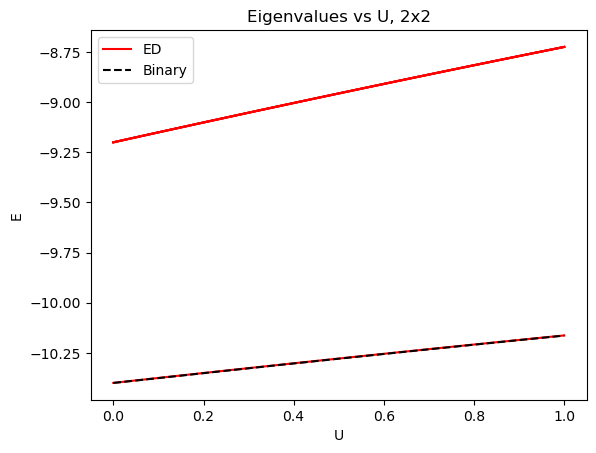

In [17]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')

plt.plot(U_sweep, solved_eigvals[0], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

## Reproduce Psi

In [18]:
def _Psi_qsp(H, E, init_eigvecs, degeneracy_idx, dim, poly, kappa):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    N = jnp.linalg.norm(M)
    M = M / N
    
    M_eigvals, M_eigvecs = jnp.linalg.eigh(M)
    M_eigvals_inv = jnp.diag(poly(M_eigvals))
    M_inv = M_eigvecs @ M_eigvals_inv @ jnp.conj(M_eigvecs.T) * 2 * kappa / N
    
    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    Heff =  jnp.real(Hij + Rij)
    Heff_eigvals, Heff_eigvecs = jnp.linalg.eigh(Heff)

    
    
    Proj_Psi = degeneracy_eigvecs @ Heff_eigvecs
    Psi = Proj_Psi + Q @ M_inv @ Q @ H @ Proj_Psi

    Psi_norm = jnp.zeros_like(Psi)
    for i in range(degeneracy_dim):
        Psi_norm = Psi_norm.at[:,i].set(Psi[:,i]/jnp.linalg.norm(Psi[:,i]))

    return Psi_norm

In [19]:
ground_state_eigval_qsp = solved_eigvals[0 ,-1]
ground_state_eigvec_qsp = _Psi_qsp(H=H_reduced, E=solved_eigvals[0 ,-1], init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx,
                                    dim=reduced_dim, poly=poly, kappa=kappa)[:, 0].T

## Green's function

## Annihilation and creation operator


In [20]:
X = sp.csr_matrix([[0, 1], [1, 0]], dtype=complex)
Y = sp.csr_matrix([[0, -1j], [1j, 0]], dtype=complex)
Z = sp.csr_matrix([[1, 0], [0, -1]], dtype=complex)
I = sp.eye(2, dtype=complex, format='csr')

def reduced_annihilation_operator(n_site, index, indices):
    N = 2 * n_site

    Z_tensor = sp.eye(1, dtype=complex, format='csr')
    for _ in range(index - 1):
        Z_tensor = sp.kron(Z_tensor, Z, format='csr')

    middle_part = 0.5 * (X + 1j * Y)
    
    I_tensor = sp.eye(1, dtype=complex, format='csr')
    for _ in range(N - index):
        I_tensor = sp.kron(I_tensor, I, format='csr')
    
    a_i = sp.kron(sp.kron(Z_tensor, middle_part, format='csr'), I_tensor, format='csr')
    
    return a_i[jnp.ix_(indices, indices)].toarray()

## Retarded Green's function
### $$ G^{R}_{ij}(\omega) = \bra{\Psi_0}\hat{a}_i(\omega-(\hat{H}-E_0)+i\eta)^{-1}\hat{a}_j^\dagger\ket{\Psi_0} +\bra{\Psi_0}\hat{a}_j^\dagger(\omega+(\hat{H}-E_0)+i\eta)^{-1}\hat{a}_i\ket{\Psi_0} $$

In [21]:
def reduced_retarded_Greens_func_ij(H, z, ground_eigval, ground_eigvec, index_i, index_j, n_site, indices):

    dim = len(indices)
    
    a_i = reduced_annihilation_operator(n_site, index_i, indices)
    a_j = reduced_annihilation_operator(n_site, index_j, indices)

    eta = 1E-5

    plus_denominator = (z + ground_eigval + 1j * eta) * jnp.eye(dim) - H
    minus_denominator = (z - ground_eigval + 1j * eta) * jnp.eye(dim) + H

    plus_denominator_inv = jnp.linalg.inv(plus_denominator)
    minus_denominator_inv = jnp.linalg.inv(minus_denominator)

    Gij = ground_eigvec @ a_i @ plus_denominator_inv @ a_j.T @ ground_eigvec \
            + ground_eigvec @ a_j.T @ minus_denominator_inv @ a_i @ ground_eigvec
    
    return Gij

In [22]:
singularity_energy = jnp.array([])
Exact_ground_state = H_reduced_eigvals[0]

for En in n_electrons_eigvals[ground_state_electron_counts-1]:
    singularity_energy = jnp.append(singularity_energy, Exact_ground_state-En)
for En in n_electrons_eigvals[ground_state_electron_counts+1]:
    singularity_energy = jnp.append(singularity_energy, En-Exact_ground_state)
singularity_energy = singularity_energy.sort()
print(singularity_energy)

[-12.96318101 -12.96318101 -11.36318101 -11.36318101 -11.36318101
 -11.36318101  -4.96318101  -4.96318101   1.43891547   1.43891547
   1.43891547   1.43891547   3.0280743    3.0280743    7.36318101
   7.36318101   7.36318101   7.36318101   7.59117914   7.59117914
   8.0609283    8.0609283    8.08826379   8.08826379   8.13150194
   8.13150194   8.96318101   8.96318101   8.96318101   8.96318101
   8.96318101   8.96318101   8.96318101   8.96318101   9.67880754
   9.67880754   9.67880754   9.67880754   9.71961452   9.71961452
   9.71961452   9.71961452  11.08448649  11.08448649  14.27693814
  14.27693814  14.27693814  14.27693814  15.36318101  15.36318101
  15.36318101  15.36318101  15.63809823  15.63809823  16.12996678
  16.12996678  16.13518288  16.13518288  16.14412824  16.14412824
  17.50162936  17.50162936  17.50162936  17.50162936]


In [23]:
E_range = jnp.linspace(singularity_energy[0] - 0.5, singularity_energy[-1] + 0.5, 400)

In [24]:
Im_tr_G_values_qsp = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = ground_state_eigval_qsp, ground_eigvec = ground_state_eigvec_qsp
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values_qsp = Im_tr_G_values_qsp.at[i].set(jnp.imag(tr_G_value))

In [25]:
Im_tr_G_values = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = H_reduced_eigvals[0], ground_eigvec = H_reduced_eigvecs[:, 0]
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values = Im_tr_G_values.at[i].set(jnp.imag(tr_G_value))

# Fig

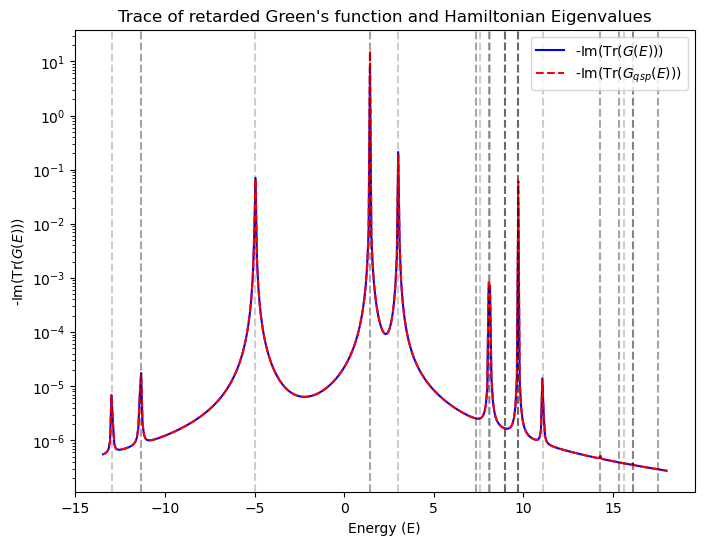

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values_qsp, label=r'-Im(Tr$(G_{qsp}(E)))$', color='red', linestyle='--')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

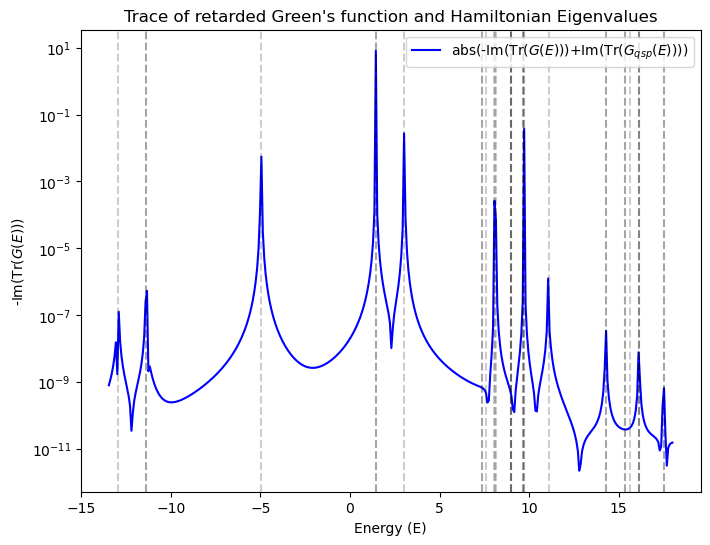

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, jnp.abs(-Im_tr_G_values+Im_tr_G_values_qsp), label=r'abs(-Im(Tr($G(E)$))+Im(Tr($G_{qsp}(E)$)))', color='blue')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

# error $ = 10^{-6}$

In [28]:
kappa = 80
error = 6
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [29]:
U_sweep = jnp.linspace(0, U, 11)

In [31]:
solved_eigvals = [[H0_eigvals_updated[0].item()]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(1):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 14 iterations.
-10.375136979626127
solve: 2
Converged in 14 iterations.
-10.350543655306932
solve: 3
Converged in 14 iterations.
-10.326217835306823
solve: 4
Converged in 14 iterations.
-10.302156573569317
solve: 5
Converged in 14 iterations.
-10.278356937423501
solve: 6
Converged in 14 iterations.
-10.254816008245328
solve: 7
Converged in 14 iterations.
-10.231530882087553
solve: 8
Converged in 14 iterations.
-10.208498670316406
solve: 9
Converged in 14 iterations.
-10.185716500259428
solve: 10
Converged in 14 iterations.
-10.163181515861684


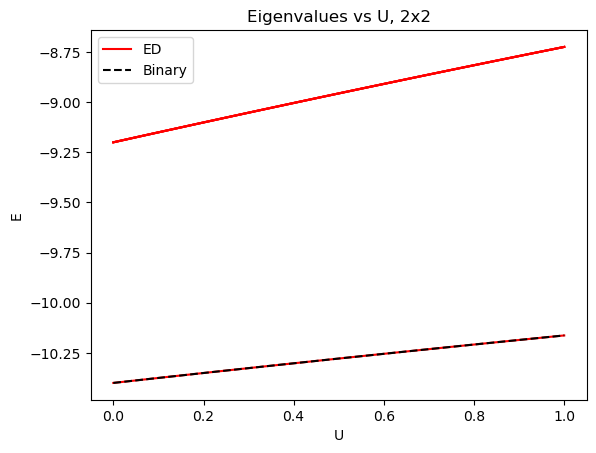

In [32]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')

plt.plot(U_sweep, solved_eigvals[0], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

## Reproduce Psi

In [33]:
ground_state_eigval_qsp = solved_eigvals[0 ,-1]
ground_state_eigvec_qsp = _Psi_qsp(H=H_reduced, E=solved_eigvals[0 ,-1], init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx,
                                    dim=reduced_dim, poly=poly, kappa=kappa)[:, 0].T

In [34]:
Im_tr_G_values_qsp = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = ground_state_eigval_qsp, ground_eigvec = ground_state_eigvec_qsp
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values_qsp = Im_tr_G_values_qsp.at[i].set(jnp.imag(tr_G_value))

# Fig

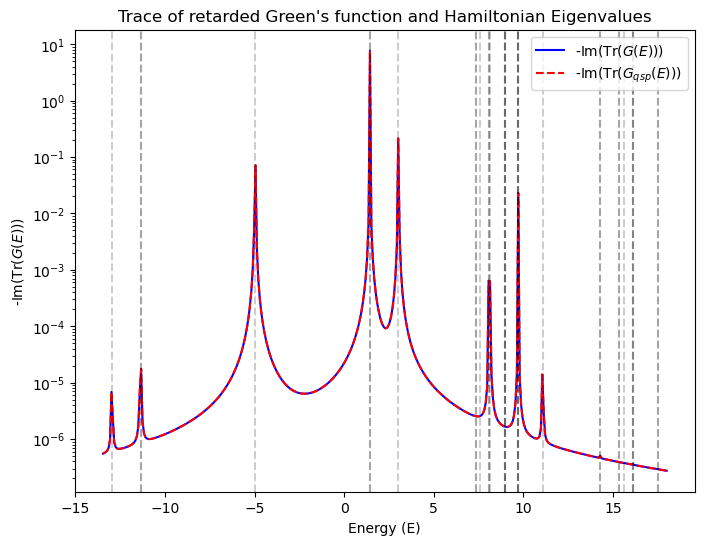

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values_qsp, label=r'-Im(Tr$(G_{qsp}(E)))$', color='red', linestyle='--')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

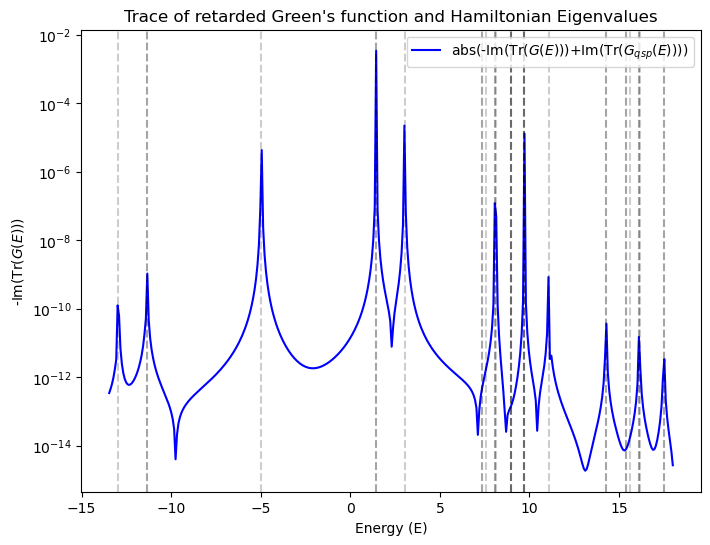

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, jnp.abs(-Im_tr_G_values+Im_tr_G_values_qsp), label=r'abs(-Im(Tr($G(E)$))+Im(Tr($G_{qsp}(E)$)))', color='blue')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

# error $ = 10^{-8}$

In [37]:
kappa = 80
error = 8
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [38]:
U_sweep = jnp.linspace(0, U, 11)

In [39]:
solved_eigvals = [[H0_eigvals_updated[0].item()]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(1):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 21 iterations.
-10.375136229200063
solve: 2
Converged in 21 iterations.
-10.350542920648675
solve: 3
Converged in 21 iterations.
-10.326217121438704
solve: 4
Converged in 21 iterations.
-10.302155884827716
solve: 5
Converged in 21 iterations.
-10.278356277136371
solve: 6
Converged in 21 iterations.
-10.254815378612964
solve: 7
Converged in 21 iterations.
-10.231530284258604
solve: 8
Converged in 21 iterations.
-10.208498104614149
solve: 9
Converged in 21 iterations.
-10.185715966509822
solve: 10
Converged in 21 iterations.
-10.163181013778178


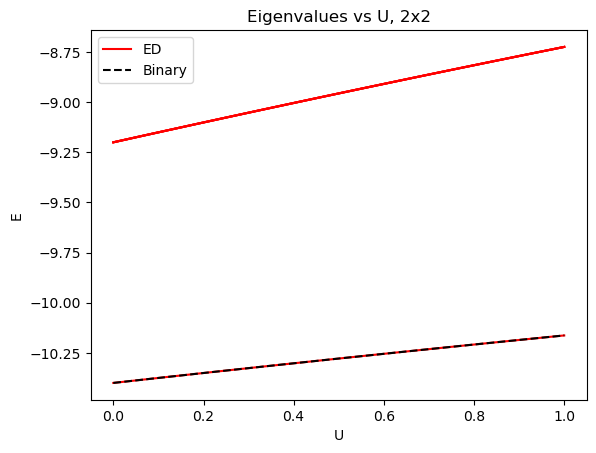

In [40]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')

plt.plot(U_sweep, solved_eigvals[0], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

## Reproduce Psi

In [41]:
ground_state_eigval_qsp = solved_eigvals[0 ,-1]
ground_state_eigvec_qsp = _Psi_qsp(H=H_reduced, E=solved_eigvals[0 ,-1], init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx,
                                    dim=reduced_dim, poly=poly, kappa=kappa)[:, 0].T

In [42]:
Im_tr_G_values_qsp = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = ground_state_eigval_qsp, ground_eigvec = ground_state_eigvec_qsp
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values_qsp = Im_tr_G_values_qsp.at[i].set(jnp.imag(tr_G_value))

# Fig

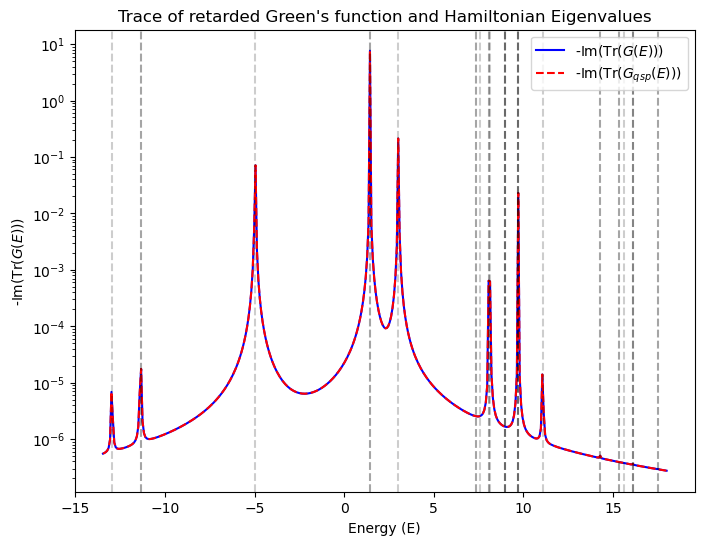

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values_qsp, label=r'-Im(Tr$(G_{qsp}(E)))$', color='red', linestyle='--')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

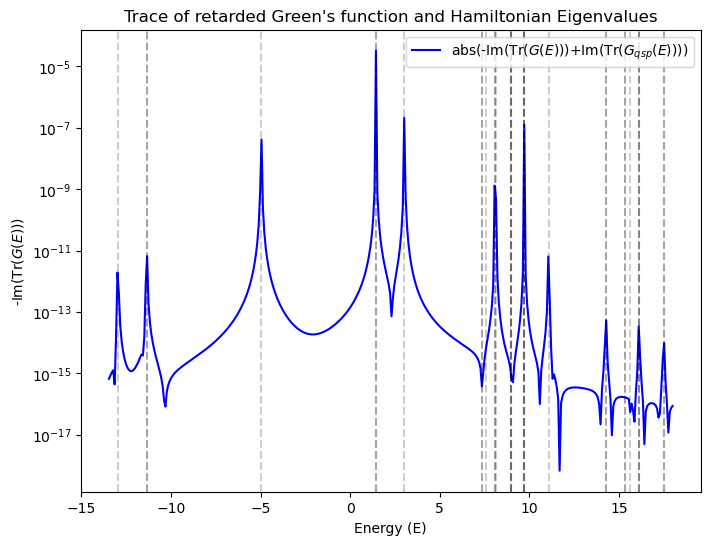

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, jnp.abs(-Im_tr_G_values+Im_tr_G_values_qsp), label=r'abs(-Im(Tr($G(E)$))+Im(Tr($G_{qsp}(E)$)))', color='blue')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

# Wegstien's method

# error $ = 10^{-3}$

In [45]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [46]:
U_sweep = jnp.linspace(0, U, 11)

In [47]:
solved_eigvals = [[H0_eigvals_updated[0].item()]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(1):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 1 iterations.
-10.375136982782479
solve: 2
Converged in 1 iterations.
-10.350545477437224
solve: 3
Converged in 1 iterations.
-10.32622178141866
solve: 4
Converged in 1 iterations.
-10.30216220236232
solve: 5
Converged in 1 iterations.
-10.278363098093969
solve: 6
Converged in 1 iterations.
-10.25482090542997
solve: 7
Converged in 1 iterations.
-10.23153215846222
solve: 8
Converged in 1 iterations.
-10.208493497546586
solve: 9
Converged in 1 iterations.
-10.18570167054676
solve: 10
Converged in 1 iterations.
-10.163153528047278


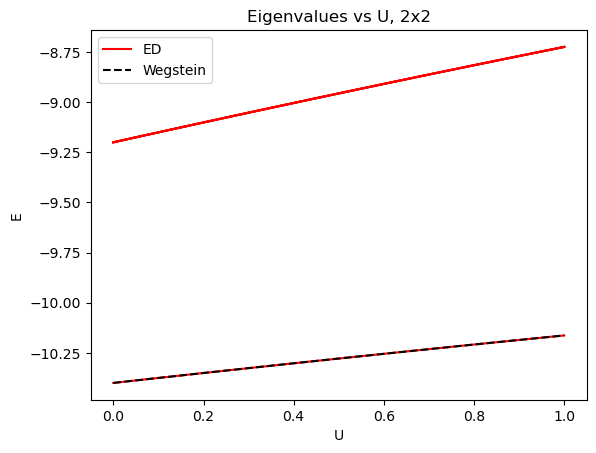

In [48]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')

plt.plot(U_sweep, solved_eigvals[0], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

## Reproduce Psi

In [49]:
ground_state_eigval_qsp = solved_eigvals[0 ,-1]
ground_state_eigvec_qsp = _Psi_qsp(H=H_reduced, E=solved_eigvals[0 ,-1], init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx,
                                    dim=reduced_dim, poly=poly, kappa=kappa)[:, 0].T

In [50]:
Im_tr_G_values_qsp = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = ground_state_eigval_qsp, ground_eigvec = ground_state_eigvec_qsp
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values_qsp = Im_tr_G_values_qsp.at[i].set(jnp.imag(tr_G_value))

# Fig

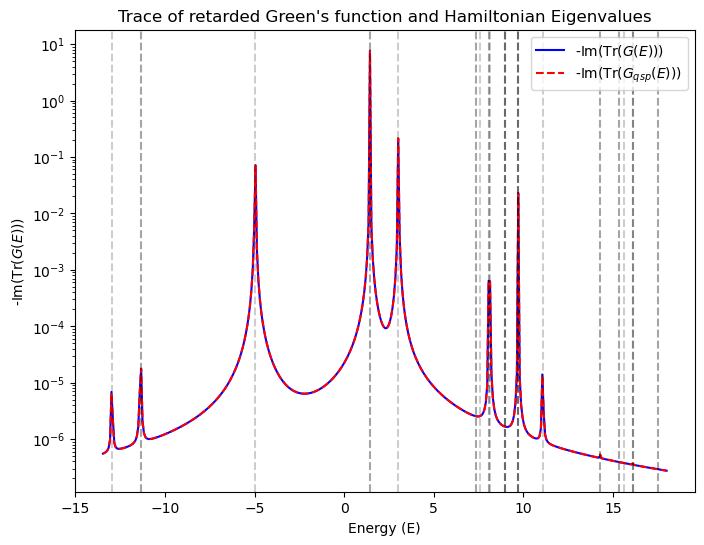

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values_qsp, label=r'-Im(Tr$(G_{qsp}(E)))$', color='red', linestyle='--')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

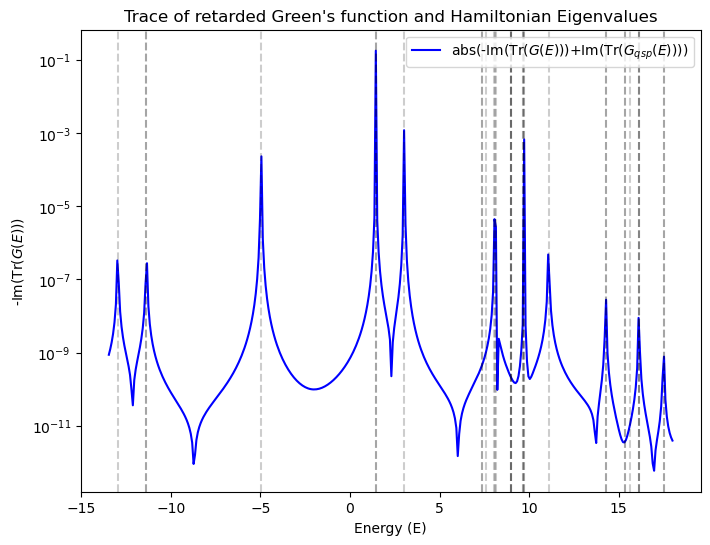

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, jnp.abs(-Im_tr_G_values+Im_tr_G_values_qsp), label=r'abs(-Im(Tr($G(E)$))+Im(Tr($G_{qsp}(E)$)))', color='blue')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

# error $ = 10^{-6}$

In [53]:
kappa = 80
error = 6
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [54]:
U_sweep = jnp.linspace(0, U, 11)

In [55]:
solved_eigvals = [[H0_eigvals_updated[0].item()]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(1):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 1 iterations.
-10.375136220957538
solve: 2
Converged in 1 iterations.
-10.350542905201989
solve: 3
Converged in 2 iterations.
-10.326217093906363
solve: 4
Converged in 2 iterations.
-10.302155840977695
solve: 5
Converged in 2 iterations.
-10.278356213733494
solve: 6
Converged in 2 iterations.
-10.254815293539725
solve: 7
Converged in 2 iterations.
-10.231530176440597
solve: 8
Converged in 2 iterations.
-10.20849797378991
solve: 9
Converged in 2 iterations.
-10.185715812902723
solve: 10
Converged in 2 iterations.
-10.16318083771859


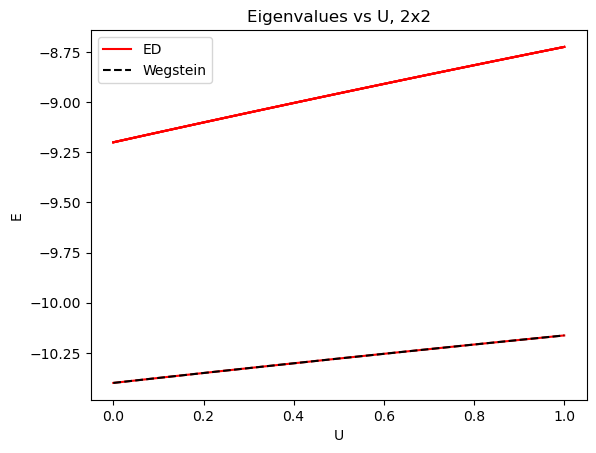

In [56]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')

plt.plot(U_sweep, solved_eigvals[0], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

## Reproduce Psi

In [57]:
ground_state_eigval_qsp = solved_eigvals[0 ,-1]
ground_state_eigvec_qsp = _Psi_qsp(H=H_reduced, E=solved_eigvals[0 ,-1], init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx,
                                    dim=reduced_dim, poly=poly, kappa=kappa)[:, 0].T

In [58]:
Im_tr_G_values_qsp = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = ground_state_eigval_qsp, ground_eigvec = ground_state_eigvec_qsp
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values_qsp = Im_tr_G_values_qsp.at[i].set(jnp.imag(tr_G_value))

# Fig

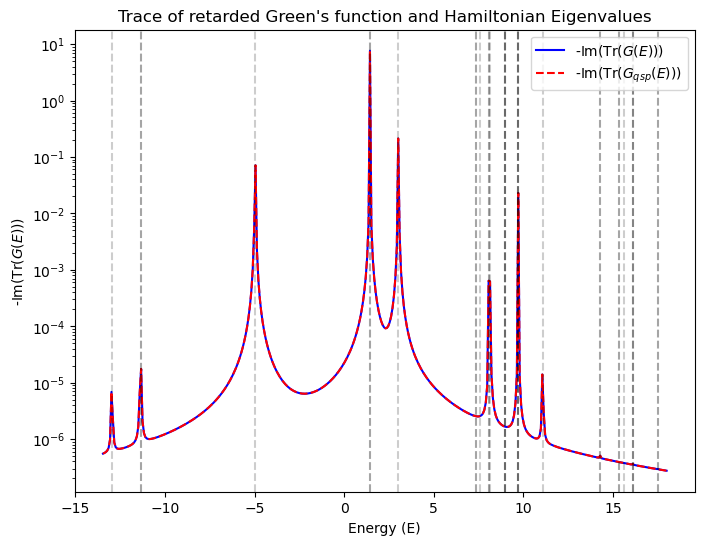

In [59]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values_qsp, label=r'-Im(Tr$(G_{qsp}(E)))$', color='red', linestyle='--')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

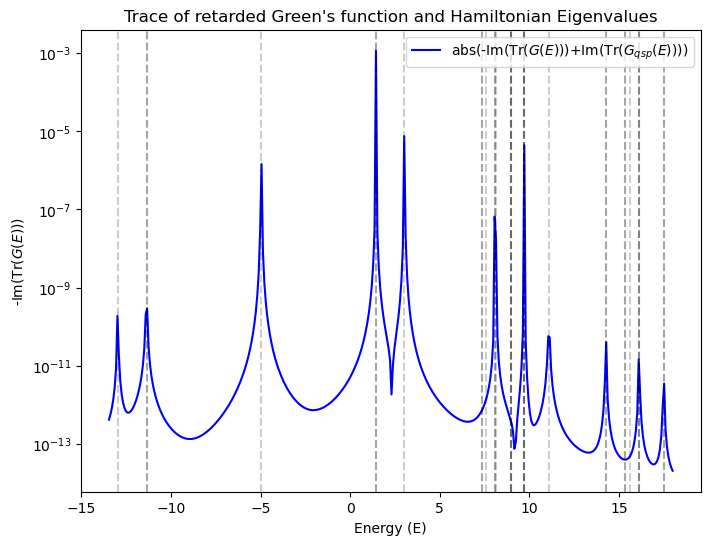

In [60]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, jnp.abs(-Im_tr_G_values+Im_tr_G_values_qsp), label=r'abs(-Im(Tr($G(E)$))+Im(Tr($G_{qsp}(E)$)))', color='blue')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

# error $ = 10^{-8}$

In [61]:
kappa = 80
error = 8
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [62]:
U_sweep = jnp.linspace(0, U, 11)

In [63]:
solved_eigvals = [[H0_eigvals_updated[0].item()]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(1):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 34 iterations.
-10.375136223273348
solve: 2
Converged in 11 iterations.
-10.350542914790887
solve: 3
Converged in 2 iterations.
-10.32621711564985
solve: 4
Converged in 2 iterations.
-10.302155879111796
solve: 5
Converged in 2 iterations.
-10.278356271491694
solve: 6
Converged in 2 iterations.
-10.254815373042192
solve: 7
Converged in 2 iterations.
-10.231530278763556
solve: 8
Converged in 2 iterations.
-10.20849809919585
solve: 9
Converged in 2 iterations.
-10.18571596116853
solve: 10
Converged in 2 iterations.
-10.163181008515211


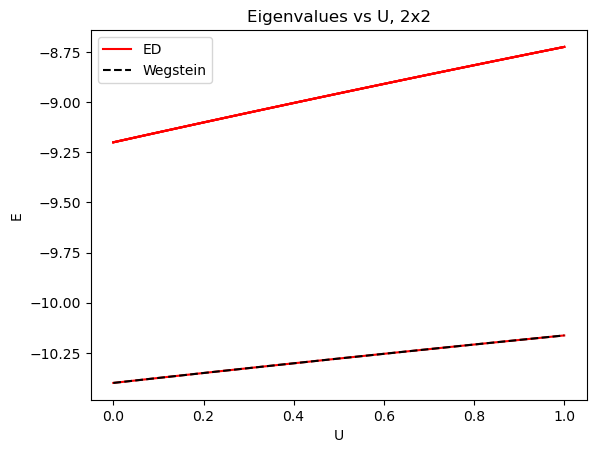

In [64]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')

plt.plot(U_sweep, solved_eigvals[0], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

## Reproduce Psi

In [65]:
ground_state_eigval_qsp = solved_eigvals[0 ,-1]
ground_state_eigvec_qsp = _Psi_qsp(H=H_reduced, E=solved_eigvals[0 ,-1], init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx,
                                    dim=reduced_dim, poly=poly, kappa=kappa)[:, 0].T

In [66]:
Im_tr_G_values_qsp = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = ground_state_eigval_qsp, ground_eigvec = ground_state_eigvec_qsp
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values_qsp = Im_tr_G_values_qsp.at[i].set(jnp.imag(tr_G_value))

# Fig

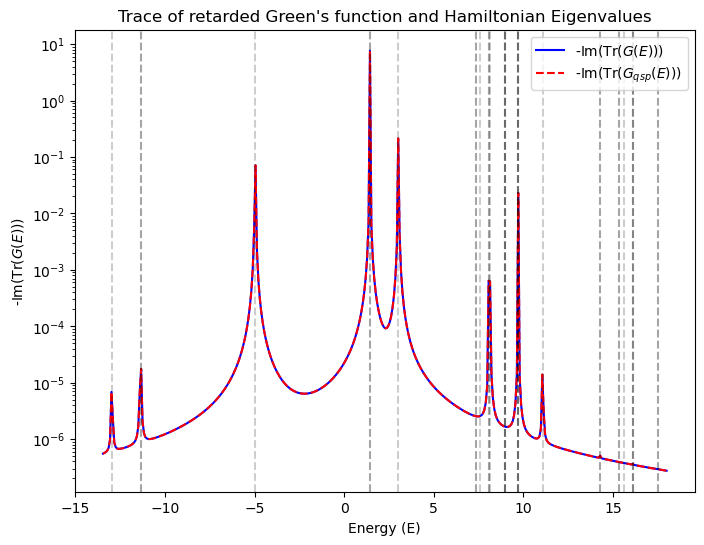

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values_qsp, label=r'-Im(Tr$(G_{qsp}(E)))$', color='red', linestyle='--')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

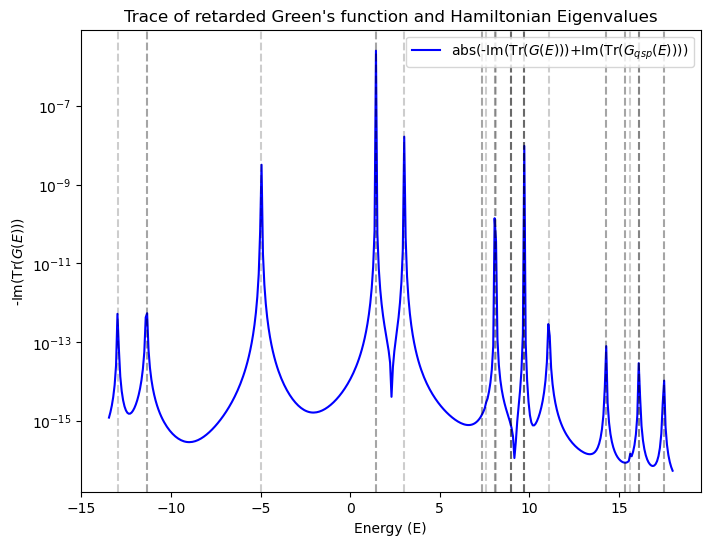

In [68]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, jnp.abs(-Im_tr_G_values+Im_tr_G_values_qsp), label=r'abs(-Im(Tr($G(E)$))+Im(Tr($G_{qsp}(E)$)))', color='blue')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()